In [11]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from scipy.interpolate import*
from ReferenceElement import *
%matplotlib inline


def RK4_Step(u, delta_t, F): #F is the derivative
    w1 = F(u)
    w2 = F(u + 0.5*delta_t*w1)
    w3 = F(u + 0.5*delta_t*w2)
    w4 = F(u + delta_t*w3)
    next_u = u + delta_t/6*(w1+2*w2+2*w3+w4)
    return next_u

def get_x_int_element(k,N,K):
    h = 1/K
    ref_int = ReferenceElement
    x_int = []
    for r_i in ref_int:
         x_int.append(k*h+(1+r_i)*h/2)
    return np.array(x_int)
def bc(x,t):
    return np.exp(-2*np.cos(2*np.pi*(x-t)))
    #return np.sin(2*np.pi*(x-t))

def f_star_k(u,k,K,N,a,alpha): #flux at x_k
    #a = 1; alpha = 1/2
    u_braces = (u[(k-1)%K][N] + u[(k)%K][0])/2
    u_brackets = u[(k-1)%K][N] - u[(k)%K][0]
    f_star = a*u_braces + np.absolute(a)*(1-alpha)/2*u_brackets
    return f_star 

def Evolve_DG(t_initial, t_final, Tstepper, CF, N,K, a, alpha, bc): # a = advection speed; alpha = some properties of the flux
    ref_ele = ReferenceElement(N)
    reference_interval = ref_ele[0]                             # r[-1,1] with optimal spacing
    M_ref_inv = ref_ele[1]
    M_ref_inv_S_ref = ref_ele[2]
    h = 1/K                                                     # width of an element, working on x[0,1]
    
    x_elements = []                                             # mapping K reference interval r[-1,1] to x[0,1]
    for k in range(K):
        element =[]
        for r_i in reference_interval:
            element.append(k*h + (1 + r_i)*h/2)
        x_elements.append(element)
    x_elements = np.array(x_elements)    # grid points
    u0_elements = bc(x_elements, t_initial)                     # array to be evolved

    #calculate dxmin for CF
    x_array = x_elements[0]
    dx_array = []
    for i in range(len(x_array)):
        dx_array.append(np.absolute(x_array[i]-x_array[i-1]))
    dx_min = np.min(dx_array)
    
    def f_star_k(u,k,K,N): #flux at x_k
        u_braces = (u[(k-1)%K][N] + u[(k)%K][0])/2
        u_brackets = u[(k-1)%K][N] - u[(k)%K][0]
        f_star = a*u_braces + np.absolute(a)*(1-alpha)/2*u_brackets
        return f_star 

    def du_dt_element_k(u,k, K, N):
        first_term = - np.matmul( M_ref_inv_S_ref , u[k]) 
        second_term = M_ref_inv[:,N] * (u[(k)%K][N]- f_star_k(u,k+1,K,N))
        third_term = -M_ref_inv[:,0] * (u[k%K][0]  - f_star_k(u,(k)%K,K,N))
        du_dt = first_term + second_term + third_term
        #print (second_term, third_term)
        return du_dt

    def DG_du_dt(u):
        du_dt = []
        for k in range(K):
            du_dt.append(du_dt_element_k(u,k,K,N))
        return np.array(du_dt)*2/h
    
    def Evolve(t_initial ,t_final, u, F, Tstepper, CF, info):
         #spatial grid-spacing
        delta_t = 1/2*CF*dx_min
        while t_initial < t_final:
            u = Tstepper(u, delta_t, F)
            t_initial += delta_t
        return t_initial, u 
    
    def nice_plot(evolved):
        nice_evolved = []
        nice_x_elements = []
        for i in range(len(evolved)):
            nice_x_element = np.linspace(x_elements[i][0],x_elements[i][-1],11,True)
            nice_evolved.append(lagrange(x_elements[i],evolved[i])(nice_x_element))
            nice_x_elements.append(nice_x_element)
        for i in range(len(nice_evolved)):
            plt.plot(nice_x_elements[i],nice_evolved[i])
            plt.scatter(x_elements[i],evolved[i])
    after = Evolve(t_initial, t_final, u0_elements, DG_du_dt, Tstepper,CF, None)
    #nice_plot(after[1])
    return x_elements, after[1], after[0]

In [12]:
Evolve_DG(0, 0.08, RK4_Step, 2**-7, 10, 6, 1, 1/2, bc)

(array([[0.        , 0.00549988, 0.01795971, 0.03623039, 0.05868682,
         0.08333333, 0.10797984, 0.13043628, 0.14870696, 0.16116679,
         0.16666667],
        [0.16666667, 0.17216655, 0.18462638, 0.20289706, 0.22535349,
         0.25      , 0.27464651, 0.29710294, 0.31537362, 0.32783345,
         0.33333333],
        [0.33333333, 0.33883321, 0.35129304, 0.36956372, 0.39202016,
         0.41666667, 0.44131318, 0.46376961, 0.48204029, 0.49450012,
         0.5       ],
        [0.5       , 0.50549988, 0.51795971, 0.53623039, 0.55868682,
         0.58333333, 0.60797984, 0.63043628, 0.64870696, 0.66116679,
         0.66666667],
        [0.66666667, 0.67216655, 0.68462638, 0.70289706, 0.72535349,
         0.75      , 0.77464651, 0.79710294, 0.81537362, 0.82783345,
         0.83333333],
        [0.83333333, 0.83883321, 0.85129304, 0.86956372, 0.89202016,
         0.91666667, 0.94131318, 0.96376961, 0.98204029, 0.99450012,
         1.        ]]),
 array([[0.17332678, 0.167827  , 0.157

In [16]:
def error_at_point_x(t_initial, t_final, Tstepper, CF, N,K, a, alpha, bc,x):
    results = Evolve_DG(t_initial, t_final, Tstepper, CF, N,K, a, alpha, bc)
    k = 0
    while x > results[0][k][-1]:
        k += 1
    point = lagrange(results[0][k],results[1][k])(x)
    analytical = bc(x,results[2])
    #error = np.abs(point-analytical)
    error = np.abs((point-analytical)/analytical)
    return np.log10(error),k

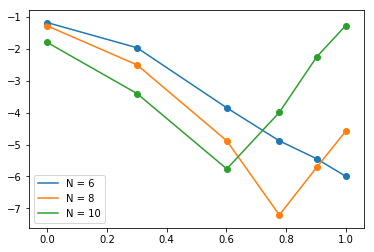

In [17]:

K_range = [1,2,4,6,8,10]
for N in [6,8,10]:
    error_same_N = []
    for K in K_range:
        error = error_at_point_x(0,1,RK4_Step,2**-7,N,K,1,1/2,bc,0.5)
        error_same_N.append(error[0])
    plt.plot(np.log10(K_range),error_same_N, label = 'N = '+str(N))
    plt.scatter(np.log10(K_range),error_same_N)
plt.legend()

In [13]:
error_at_point_x(0,1,RK4_Step,2**-7,4,4,1,1/2,bc,1/8)

(-1.7775279527388315, 0)

In [3]:
np.min([1,2,3])

1

In [7]:
a = np.array([-2,-0.5,-0.25,3,6])
b = []
for i in range(len(a)):
    b.append(np.absolute(a[i]-a[i-1]))

In [8]:
b

[8.0, 1.5, 0.25, 3.25, 3.0]